<a href="https://colab.research.google.com/github/beekal/MachieneLearningProjects/blob/staging/2.%20Deep%20Learning/Bert/Bert_Exploration_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring BERT - 101
- We will explore the  bert nlp model here. Specially focussing on 
  - How the bert tokenisation differs from other tokenisation
  - Explore Bert vocab: Word-Piece model
  - Explore Word vectors with focus to polysemy
  - Explore sentence similarity with Bert 
  - Polysemy : How same words can have different meaning based on context e.g  "bank"- "bank robber" vs "river bank"
    - Word : "Bank"
    - Context : "River Bank" vs "Financial institution Bank"
    - Sentence : Testing Embedding : bank robber went fishing on Mississippi river bank.

REF: 
- https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/




In [0]:
!pip install pytorch-pretrained-bert

import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

import logging
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline


## 1. Input Format
- Bert expects data in a specific format. They are
1. Begin / End token : [ClS] / [SEP]
2. Vocab : Frequent words used as is. Rare Words are splitted into sub-words e.g embedding => em ##bed #ding where ## indicates  word being a prt of a larger word 
3. SubWord_2_ID:
4. MaskId: indicate which are words  and which ones are empty words
5. Positional embedding : Track the position of words in the sentence e.g river bank vs money bank  by river.


### 1.1 Tokenisation : Sentence to WordToken
The ## tokenisation happens  because for spead reason, during the training process the vocabulary was limited to most common 30K words and other non-common words broken down using wordPiece Meal approach. This approach is better that treating all the uncommon words as UNK and hence disregarding the information contained in them. This way we still retain some information for the non-vocabulary words.


In [0]:
sentence = 'Testing Embedding : bank robber went fishing on Mississippi river bank.'
marked_sentence = "[CLS] " +  sentence + " [SEP]"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.tokenize(marked_sentence)
print('\n BERT Tokens :\n',tokens)

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084



 BERT Tokens :
 ['[CLS]', 'testing', 'em', '##bed', '##ding', ':', 'bank', 'robber', 'went', 'fishing', 'on', 'mississippi', 'river', 'bank', '.', '[SEP]']


In [0]:
## If you want to explore the bert vocabulary
print('VOCAB keys from 5000-5009')
print(list(tokenizer.vocab.keys())[5000:5009])

print('\n# INSPECT bank vocab')
idx = 0
for k in tokenizer.vocab.keys():
  if k == "bank":
    print(idx, k)
  idx +=1

VOCAB keys from 5000-5009
['knight', 'lap', 'survey', 'ma', '##ow', 'noise', 'billy', '##ium', 'shooting']

# INSPECT bank vocab
2924 bank


### 1.2 Token2Id : WordToken to Id

In [0]:
token_id = tokenizer.convert_tokens_to_ids(tokens)

for tup in zip(tokens, token_id):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
testing       5,604
em            7,861
##bed         8,270
##ding        4,667
:             1,024
bank          2,924
robber       27,307
went          2,253
fishing       5,645
on            2,006
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### 1.3 Mask : Word vs Blank Identifier
- Identify which ones are words and which are blanks.

In [0]:
mask = [1] * len(token_id)
print(mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### 1.4 TokenInt 2 Tensor
- Pytorch  requires  pytorch tensor and does not accept python list

In [0]:
token_pytorch_tensor = torch.tensor( [token_id])
segment_pytorch_tensor = torch.tensor( [mask] )

print('Converting token python List ', token_id)
print('token_pytorch_tensor :' ,token_pytorch_tensor)

print('\nConverting Segment List ', mask)
print('segment_pytorch_tensor ', segment_pytorch_tensor)


Converting token python List  [101, 5604, 7861, 8270, 4667, 1024, 2924, 27307, 2253, 5645, 2006, 5900, 2314, 2924, 1012, 102]
token_pytorch_tensor : tensor([[  101,  5604,  7861,  8270,  4667,  1024,  2924, 27307,  2253,  5645,
          2006,  5900,  2314,  2924,  1012,   102]])

Converting Segment List  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
segment_pytorch_tensor  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


## 2.0 Bert Model - Exploration
**Load Model**
1. Load pre-trained model
2. Put model in prediction mode i.e eval model - Turn off dropout regularisation.
3. Turn of gradient calculation, because not needed for prediction + Saves Memory + Gives Speed

In [0]:
# Load bert model
model = BertModel.from_pretrained('bert-base-uncased')

# Puts model in evaluation mode. This turns off dropout 
model.eval()


INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp_1lratgq
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

### 2.1 Encoded Layers : What it contains?
- 1. number of layers(12)
- 2. batch number :(1 sentence)
- 3. word / no. of tokens : (no of tokens in our sentence)
- 4. hidden unit/ no. of features : 768 features


In [0]:
 with torch.no_grad():
   encoded_layers,_ = model(token_pytorch_tensor, segment_pytorch_tensor)

  
print("number of layers    :", len(encoded_layers) )
layer_i = 0

print("batch number        :", len(encoded_layers[layer_i]) )
batch_i = 0

print("word / no. of tokens:", len(encoded_layers[layer_i][batch_i]) )
token_i = 0

print("hidden unit / no. of features ", len(encoded_layers[layer_i][batch_i][token_i]) )

number of layers    : 12
batch number        : 1
word / no. of tokens: 16
hidden unit / no. of features  768


### 2.2 Inspecting Word Features : Verb vs Noun
- 768 of them
- Most of the features are clustered between -2 and 2 but we also see another interesting pattern
- Verb : "went", "on" have feature values clustered around [-4.5, -6.5]. Feat value < 2
- Noun : "bank" vs "mississippi" have all feature values clustered between [-3,+3]. Feat value > 2

0 [CLS]
1 testing
2 em
3 ##bed
4 ##ding
5 :
6 bank
7 robber
8 went
9 fishing
10 on
11 mississippi
12 river
13 bank
14 .
15 [SEP]


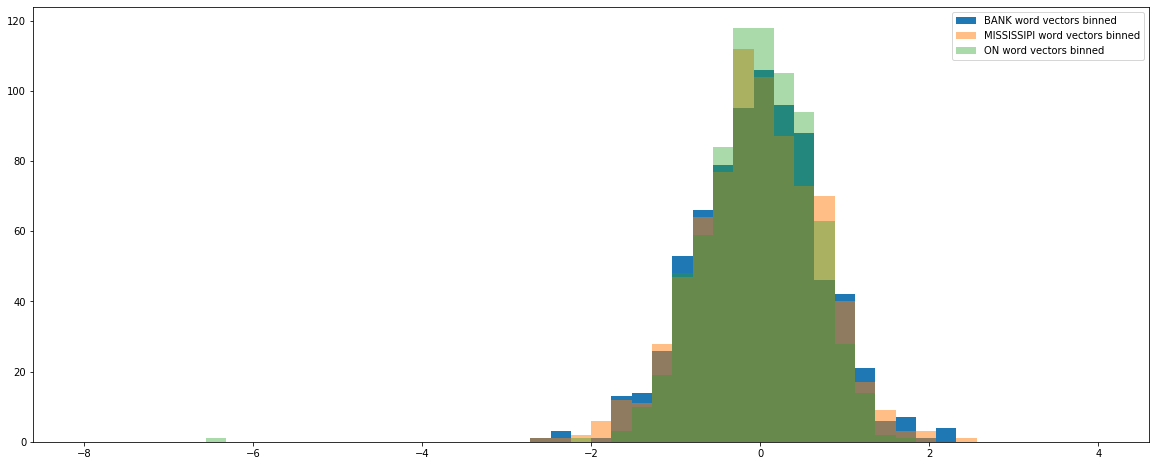

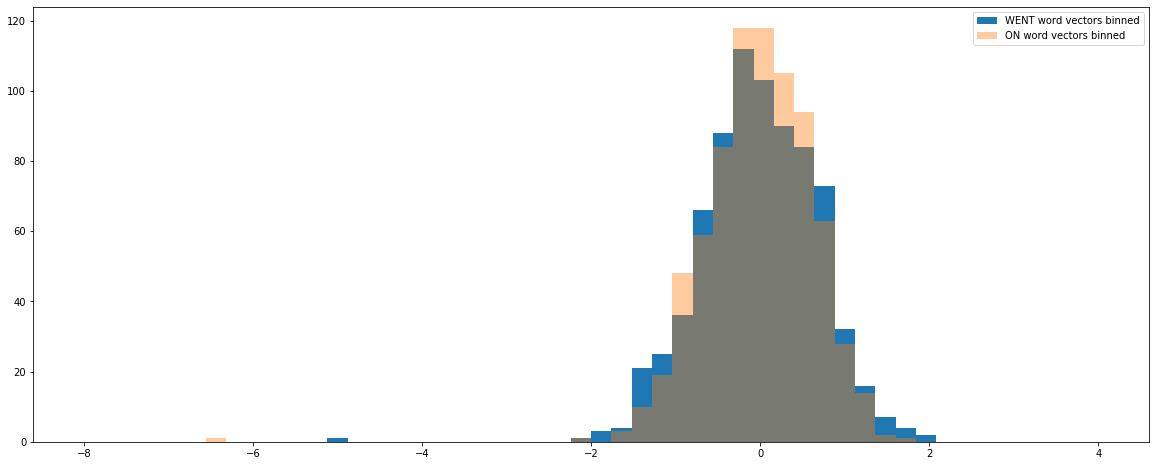

In [0]:
for idx,tk in enumerate(tokens):
  print(idx, tk)

plt.figure(figsize=(20,8) )

# encoded_layers = [#layers #batch #word_token #feature ]

plt.hist(encoded_layers[0][0][6] , bins = 50, range=(-8, 4), label="BANK word vectors binned") # bank
plt.hist(encoded_layers[0][0][11] , bins = 50, range=(-8, 4), label="MISSISSIPI word vectors binned" , alpha=0.5 ) # mississippi
plt.hist(encoded_layers[0][0][10], bins = 50, range=(-8, 4), label="ON word vectors binned", alpha=0.4) # on
plt.legend()
plt.show()

plt.figure( figsize=(20,8) )
plt.hist(encoded_layers[0][0][8], bins = 50, range=(-8, 4), label="WENT word vectors binned" ) # went
plt.hist(encoded_layers[0][0][10], bins = 50, range=(-8, 4), label="ON word vectors binned", alpha=0.4) # on
plt.legend()
plt.show()

### 2.3 Polysemy : Bank - "river bank" vs "bank robber"
- Word_loc_idx - word
- 6 bank 7 robber
- 12 river 13 bank

#batch #word_token #feature
torch.Size([1, 16, 768])


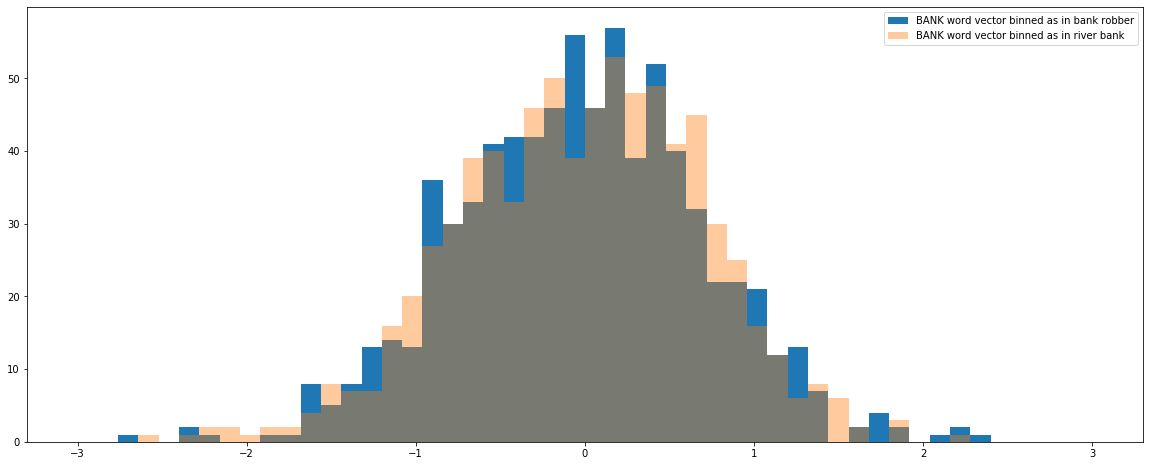

In [0]:
# encoded_layers = [#layers #batch #word_token #feature ]
print('#batch #word_token #feature')
print(encoded_layers[0].size())

plt.figure(figsize=(20,8) )
plt.hist(encoded_layers[0][0][6], bins = 50, range=(-3, 3), label="BANK word vector binned as in bank robber") # bank from bank robber
plt.hist(encoded_layers[0][0][13], bins = 50, range=(-3, 3), label="BANK word vector binned as in river bank", alpha=0.4) # bank from river bank
plt.legend()
plt.show()


### 2.4 Word Vector across diff layers
- Each word propagates across 12 layers and has different vector.
- Diff layer encode different kind of information.
- To get indv vectors, we have to combine the word vectors across diffent layers. 
- The combination can be done in a different way. 
- Bert authors tested this combination by feeding diff layers as input feature to a BiLSTM.
- Best result: Concatenation of last four layers for bert authors
- Test diff layer concatenate strategy because diff layers encode different kind of information, so the pooling strategy is dependent on the your specific task.
![](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)



In [0]:
print('num_sentence, num_words, features \n', encoded_layers[0].size()) #  [ num_sentence, num_words, features  ]

token_embeddings = torch.stack(encoded_layers, dim=0 ) # dim=0, 0-index, 1=1-index, 2=2-index, 3=3-index
print('After combining 12 layers ', token_embeddings.size())

print('\n# Remove dimension 1, batches because we do not need it as we are exploring a single sentence hence batch=1')
token_embeddings = torch.squeeze( token_embeddings, dim=1 )
print('After removing batch ', token_embeddings.size() )

print('\n# Switch layers and tokens, because we need the dimesion in  [#tokens, #layers, #features] format')
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()



num_sentence, num_words, features 
 torch.Size([1, 16, 768])
After combining 12 layers  torch.Size([12, 1, 16, 768])

# Remove dimension 1, batches because we do not need it as we are exploring a single sentence hence batch=1
After removing batch  torch.Size([12, 16, 768])

# Switch layers and tokens, because we need the dimesion in  [#tokens, #layers, #features] format


torch.Size([16, 12, 768])

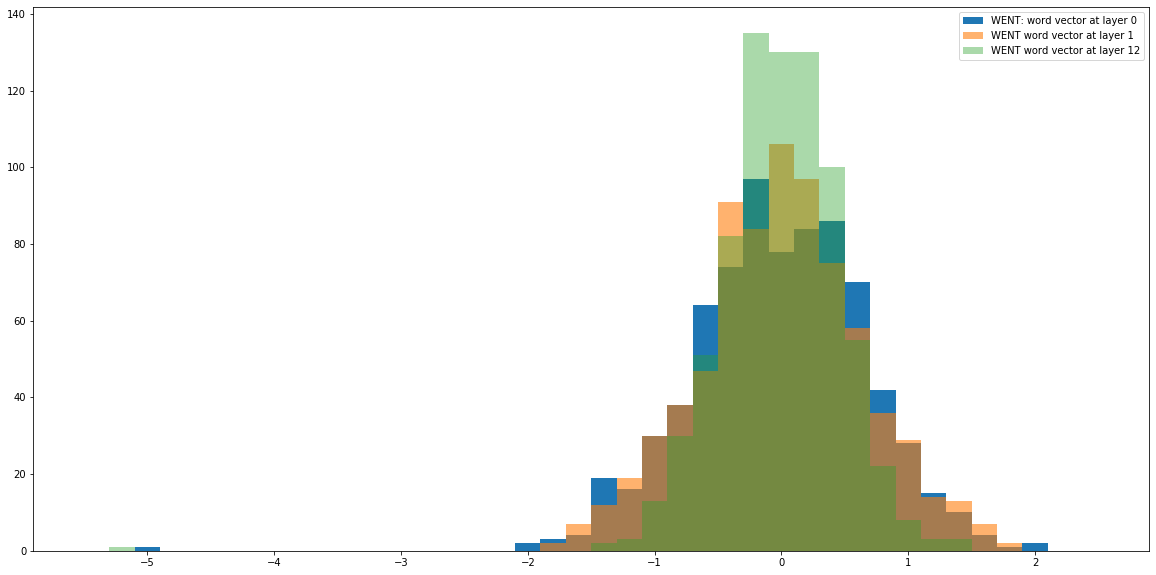

In [0]:
plt.figure(figsize=(20, 10) )
plt.hist(token_embeddings[8][0], bins = 40, range=(-5.5, 2.5), label='WENT: word vector at layer 0') # went
plt.hist(token_embeddings[8][1], bins = 40, range=(-5.5, 2.5), label='WENT word vector at layer 1', alpha=0.6 ) # went
plt.hist(token_embeddings[8][11], bins = 40, range=(-5.5, 2.5), label='WENT word vector at layer 12', alpha=0.4) # went
plt.legend()
plt.show()


### 2.5 Computing Word vectors : Sum vs Concat last four layers
- Concat last four layers 
  -  [[wv_l_12] [wv_l_11] [wv_l_10] [wv_l_9] ]
  ![](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)


In [0]:
# Trying different way of getting Word vectors
# token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([16, 12, 768])

In [0]:
def get_wv_last_four_hidden_layer_concatenated(token_embeddings):
  CLFH = []
  for tkn in token_embeddings:
    indv_word_tkn = torch.cat( (tkn[-1], tkn[-2], tkn[-3], tkn[-4]), dim=0 )
    CLFH.append(indv_word_tkn)
  return CLFH

CLFH = get_wv_last_four_hidden_layer_concatenated(token_embeddings)
print('\nCONCAT Last Four Hidden(CLFH)')
print('CLFH size post Concat is {} x {}'.format(len(CLFH), len(CLFH[0])) )


CONCAT Last Four Hidden(CLFH)
CLFH size post Concat is 16 x 3072


In [0]:
def get_wv_last_four_hidden_layer_summed(token_embeddings):
  SLFH = []  
  for tkn in token_embeddings:
    indv_word_tkn = torch.sum( tkn[-4:], dim=0 )
    SLFH.append(indv_word_tkn)
  return SLFH

SLFH = get_wv_last_four_hidden_layer_summed(token_embeddings)
print('\nSUM Last Four Hidden(SLFH) ')
print('SLFH is {} x {}'.format(len(SLFH), len(SLFH[0])) )


SUM Last Four Hidden(SLFH) 
SLFH is 16 x 768


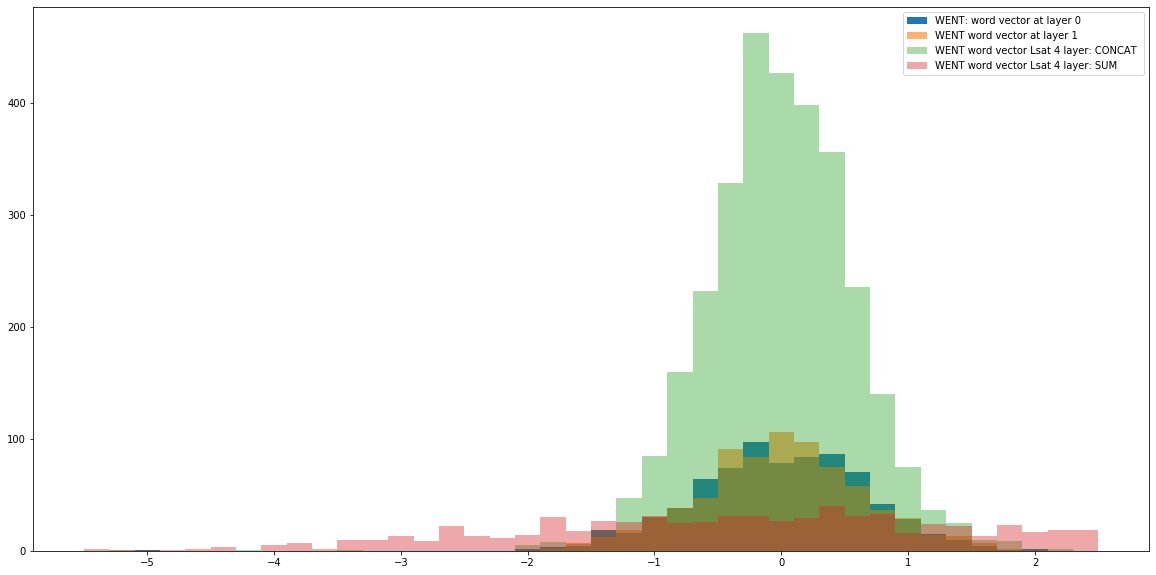

In [0]:
plt.figure(figsize=(20, 10) )
plt.hist(token_embeddings[8][0], bins = 40, range=(-5.5, 2.5), label='WENT: word vector at layer 0') # went
plt.hist(token_embeddings[8][1], bins = 40, range=(-5.5, 2.5), label='WENT word vector at layer 1', alpha=0.6 ) # went
plt.hist(CLFH[8], bins = 40, range=(-5.5, 2.5), label='WENT word vector Lsat 4 layer: CONCAT ', alpha=0.4) # went
plt.hist(SLFH[8], bins = 40, range=(-5.5, 2.5), label='WENT word vector Lsat 4 layer: SUM ', alpha=0.4) # went
plt.legend()
plt.show()


### 2.6 Polysemy CONCAT vs SUM for Bank: PLOT 
- Plotting word bank with two strategy
  - Concatenate last four hidden layer
  - Sum last four hidden layer
- Bank as in
  - Bank Robber
  - River Bank



In [0]:
for i, tkn in enumerate(tokens):
  print(i, tkn)

0 [CLS]
1 testing
2 em
3 ##bed
4 ##ding
5 :
6 bank
7 robber
8 went
9 fishing
10 on
11 mississippi
12 river
13 bank
14 .
15 [SEP]


CLFH : Displaying First 5 vector for word BANK

bank robber  tensor([ 0.6573, -0.4450, -0.2412,  0.0931,  0.6393])
river bank  tensor([ 0.1181, -0.3138, -0.0505,  0.0942,  0.9832])

SLFH : Displaying First 5 vector for word BANK

bank robber  tensor([ 1.7567, -3.2957, -0.8906,  0.3519,  2.3556])
river bank  tensor([ 1.0829, -2.5464,  0.9044, -0.3009,  4.1573])


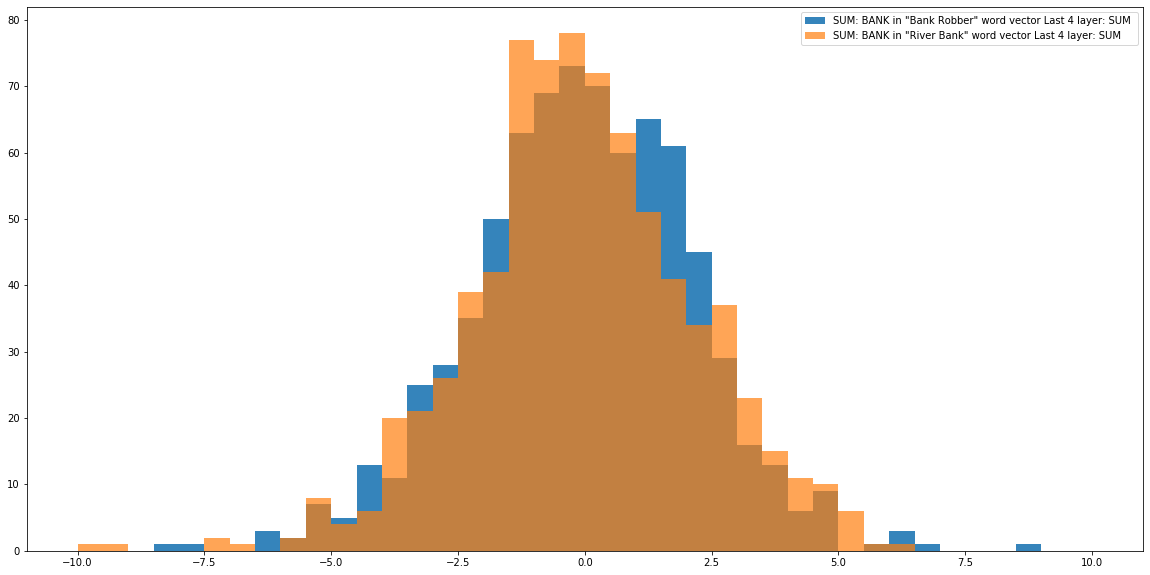

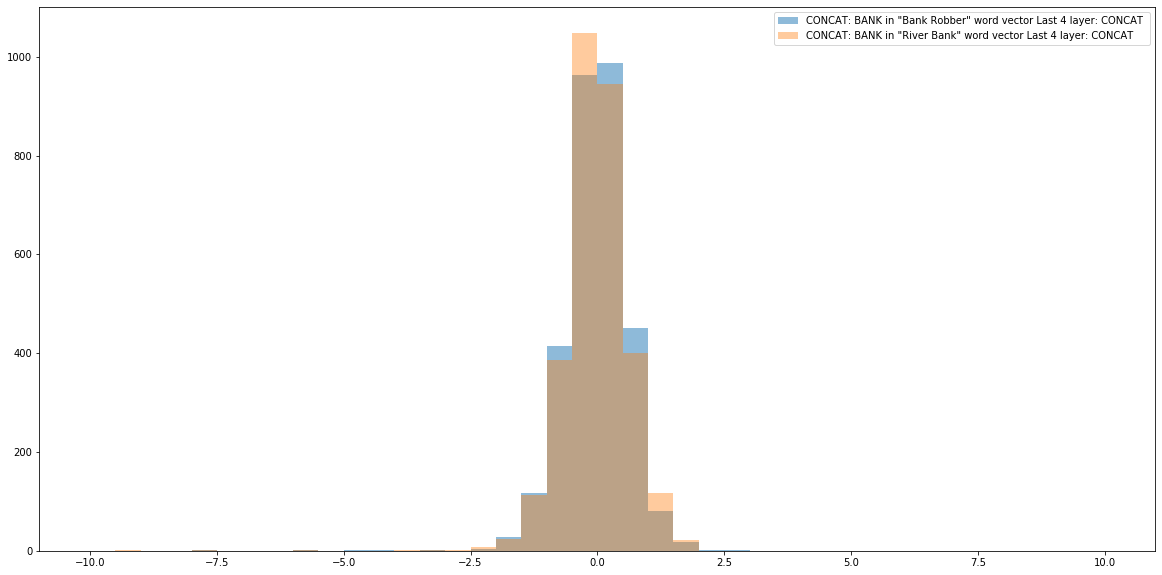

In [0]:
print('CLFH : Displaying First 5 vector for word BANK\n')
print("bank robber ", str(CLFH[6][:5]))
print("river bank ", str(CLFH[13][:5]))

print('\nSLFH : Displaying First 5 vector for word BANK\n')
print("bank robber ", str(SLFH[6][:5]))
print("river bank ", str(SLFH[13][:5]))

plt.figure(figsize=(20, 10) )
plt.hist(SLFH[6] , bins = 40, range=(-10, 10), label='SUM: BANK in "Bank Robber" word vector Last 4 layer: SUM ', alpha=0.9) # went
plt.hist(SLFH[13], bins = 40, range=(-10, 10), label='SUM: BANK in "River Bank" word vector Last 4 layer: SUM ', alpha=0.7) # went
plt.legend()
plt.show()

plt.figure(figsize=(20, 10) )
plt.hist(CLFH[6] , bins = 40, range=(-10, 10), label='CONCAT: BANK in "Bank Robber" word vector Last 4 layer: CONCAT ', alpha=0.5) # went
plt.hist(CLFH[13], bins = 40, range=(-10, 10), label='CONCAT: BANK in "River Bank" word vector Last 4 layer: CONCAT ', alpha=0.4) # went
plt.legend()
plt.show()


### 2.7 Cosine Similarity : "Bank Robber vs River Bank"

In [0]:
from scipy.spatial.distance import cosine

diff_bank_when_summed       = 1 - cosine(SLFH[6], SLFH[13])
diff_bank_when_concatenated = 1 - cosine(CLFH[6], CLFH[13])

print('Cosine Diff for last four hidden layer summed ', diff_bank_when_summed)
print('Cosine Diff for last four hidden layer concatenated ', diff_bank_when_concatenated)

Cosine Diff for last four hidden layer summed  0.7252109050750732
Cosine Diff for last four hidden layer concatenated  0.721464216709137
